In [43]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import TrueNegatives, TruePositives, FalseNegatives, FalsePositives, F1Score
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# 데이터셋 생성

In [44]:
import os

files = os.listdir('./images/Bicycle')
length = len(files)
X = np.empty((length*2, 100, 100, 3))
Y = np.empty((length*2,))
for i in range(length):
    x = cv2.imread(f"./images/Bicycle/{files[i]}")
    X[i] = cv2.resize(x, (100, 100))
    Y[i] = 1

files = os.listdir('./images/Other')
for i in range(length):
    x = cv2.imread(f"./images/Other/{files[i]}")
    X[i+length] = cv2.resize(x, (100, 100))
    Y[i+length] = 0


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

In [46]:
print(X_train.shape)
print(X_test.shape)
print( y_train.shape)
print(y_test.shape)

(1170, 100, 100, 3)
(390, 100, 100, 3)
(1170,)
(390,)


# 모델 생성

In [47]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(100, 100, 3)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [48]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=[
        'accuracy',
        F1Score(), 
        TruePositives(name='TP'),
        TrueNegatives(name='TN'),
        FalsePositives(name='FP'),
        FalseNegatives(name='FN'),
    ],
)

In [63]:
modelpath="./motorcycle.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

In [64]:

history = model.fit(X_train, y_train, validation_split=0.25, epochs=30, batch_size=100, verbose='auto', callbacks=[early_stopping_callback,checkpointer])

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9954 - f1_score: 0.6817 - TP: 436.0000 - TN: 437.0000 - FP: 2.0000 - FN: 2.0000    
Epoch 1: val_loss improved from inf to 1.85689, saving model to .\motorcycle.hdf5
9/9 [==============================] - 28s 3s/step - loss: 0.0196 - accuracy: 0.9954 - f1_score: 0.6817 - TP: 436.0000 - TN: 437.0000 - FP: 2.0000 - FN: 2.0000 - val_loss: 1.8569 - val_accuracy: 0.8191 - val_f1_score: 0.6773 - val_TP: 121.0000 - val_TN: 119.0000 - val_FP: 25.0000 - val_FN: 28.0000
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9920 - f1_score: 0.6738 - TP: 433.0000 - TN: 437.0000 - FP: 2.0000 - FN: 5.0000
Epoch 2: val_loss improved from 1.85689 to 1.71798, saving model to .\motorcycle.hdf5
9/9 [==============================] - 26s 3s/step - loss: 0.0244 - accuracy: 0.9920 - f1_score: 0.6738 - TP: 433.0000 - TN: 437.0000 - FP: 2.0000 - FN: 5.0000 - val_loss: 1.7180 - val_accuracy: 

In [65]:
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

13/13 [==============================] - 3s 223ms/step - loss: 1.4167 - accuracy: 0.8179 - f1_score: 0.6632 - TP: 154.0000 - TN: 165.0000 - FP: 32.0000 - FN: 39.0000


[1.4167165756225586,
 0.8179486989974976,
 array([0.66323024], dtype=float32),
 154.0,
 165.0,
 32.0,
 39.0]

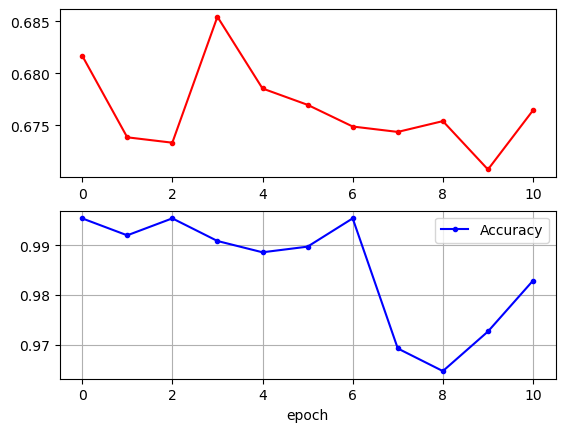

In [66]:
f1_score = history.history['f1_score']
accuracy = history.history['accuracy']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(f1_score))
plt.subplot(211)
plt.plot(x_len, f1_score, marker='.', c="red", label='F1 Score')
plt.subplot(212)
plt.plot(x_len, accuracy, marker='.', c="blue", label='Accuracy')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('')
plt.show()

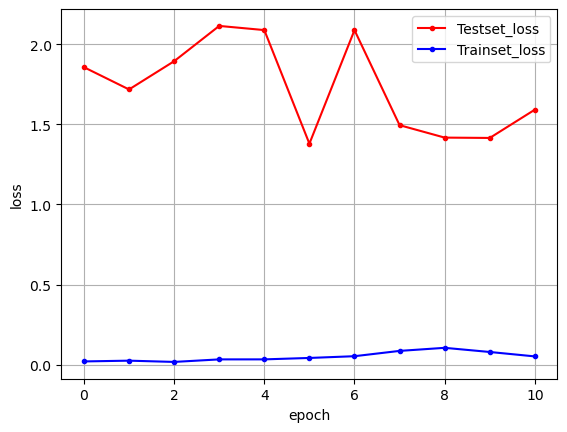

In [67]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vloss = history.history['val_loss'][:]
y_loss = history.history['loss'][:]

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

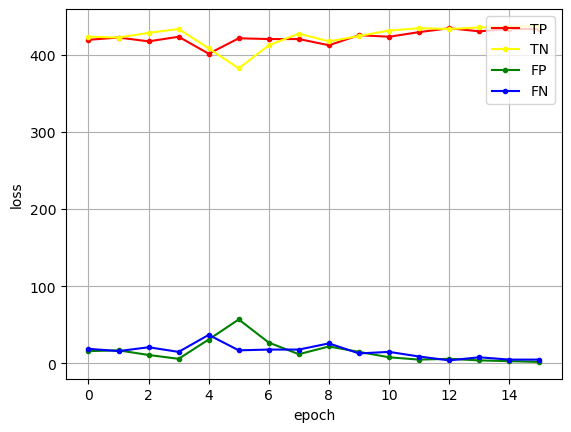

In [62]:
TP = history.history['TP']
TN = history.history['TN']
FP = history.history['FP']
FN = history.history['FN']
x_len = np.arange(len(TP))
plt.plot(x_len, TP, marker='.', c="red", label='TP')
plt.plot(x_len, TN, marker='.', c="yellow", label='TN')
plt.plot(x_len, FP, marker='.', c="green", label='FP')
plt.plot(x_len, FN, marker='.', c="blue", label='FN')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [55]:
model.save("motorcycle.h5")